## Stage 1: Load Visium HD data and Generate HE labels

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import os
os.chdir('/import/macyang_home2/ychenlp/Code/SpotFPN')
import bin2cell as b2c

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
#create directory for stardist input/output files
os.makedirs("stardist", exist_ok=True)

In [35]:
path = "/import/macyang_home1/share/ychenlp/square_002um/"
source_image_path = "/import/macyang_home1/share/ychenlp/Visium_HD_Mouse_Brain_tissue_image.tif"
spaceranger_image_path = "/import/macyang_home1/share/ychenlp/spatial"
he_label = "/import/macyang_home1/share/ychenlp/he.npz"
save_path = "/import/macyang_home1/share/ychenlp/preprocessed/"

In [4]:
adata = b2c.read_visium(path, 
                        source_image_path = source_image_path, 
                        spaceranger_image_path = spaceranger_image_path
                       )
adata.var_names_make_unique()
adata

anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 6296688 × 19059
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
mpp = 0.5

b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he.tiff")

In [91]:
mpp = 8

b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he_8um.tiff")

bin2cell.py (687): Setting element `.obsm['spatial_cropped']` of view, initializing view as actual.


In [92]:
mpp = 2

b2c.scaled_he_image(adata, mpp=mpp, save_path="stardist/he_2um.tiff")

In [6]:
adata

AnnData object with n_obs × n_vars = 6296688 × 19059
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped'

In [9]:
b2c.insert_labels(adata, 
                  labels_npz_path=he_label, 
                  basis="spatial", 
                  spatial_key="spatial_cropped",
                  mpp=mpp, 
                  labels_key="labels_he"
                 )

3585452170.py (11): Trying to modify attribute `.obs` of view, initializing view as actual.


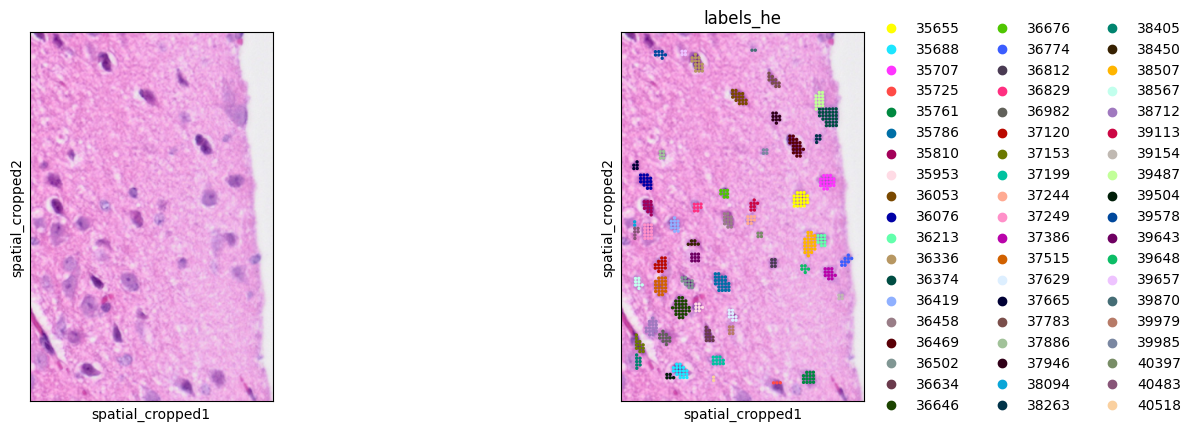

In [10]:
mask = ((adata.obs['array_row'] >= 1450) & 
        (adata.obs['array_row'] <= 1550) & 
        (adata.obs['array_col'] >= 250) & 
        (adata.obs['array_col'] <= 450)
       )

bdata = adata[mask]

#0 means unassigned
bdata = bdata[bdata.obs['labels_he']>0]
bdata.obs['labels_he'] = bdata.obs['labels_he'].astype(str)

sc.pl.spatial(bdata, color=[None, "labels_he"], img_key="0.5_mpp", basis="spatial_cropped")

In [36]:
# Save 
adata.write(save_path + "labeled_adata.h5ad")

## Stage 2: Generate corresponding scRNA data reference

In [21]:
path_ref = "/import/macyang_home1/share/ychenlp/scrna_mouse_brain.h5ad"

In [22]:
adata_ref = sc.read(path_ref)

In [23]:
adata_ref

AnnData object with n_obs × n_vars = 199993 × 31053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_name', 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color

In [24]:
celltype_col = "subclass_label"

In [25]:
# Pick highly variable genes
temp = sc.read("/import/macyang_home1/share/ychenlp/adata_with_he_nuclei_hvg_2000.h5ad")
hvg_genes = temp.var_names

In [26]:
hvg_genes

Index(['Csf2rb', 'Prex1', 'Onecut2', 'Arhgap45', 'Zcchc12', 'Hpca', 'Ntrk3',
       'Nmb', 'Arhgap36', 'Tcf7l1',
       ...
       'Rimbp2', 'Pdzrn3', 'Abi3bp', 'Rab3c', 'Robo1', 'Tpcn2', 'Myog',
       'Nrsn2', 'Cul4b', 'Dusp27'],
      dtype='object', length=2000)

In [27]:
adata_ref = adata_ref[:, hvg_genes]

In [48]:
# Save
adata_ref.write(save_path + "adata_ref_hvg2000.h5ad")
# Save gene names
np.save(save_path + "hvg_genes.npy", hvg_genes)

In [52]:
# Compute basis for each celltype
sc.pp.filter_cells(adata_ref, min_genes=1)
sc.pp.normalize_total(adata_ref, target_sum=1)
celltype_list = list(sorted(set(adata_ref.obs['subclass_label'].values.astype(str))))

basis = np.zeros((len(celltype_list), len(adata_ref.var.index)))
import scipy
for i in range(len(celltype_list)):
    c = celltype_list[i]
    tmp = adata_ref[adata_ref.obs['subclass_label'].values.astype(str) == c, :].X
    if scipy.sparse.issparse(tmp):
        tmp = tmp.toarray()
    basis[i, :] = np.mean(tmp, axis=0).reshape((-1))

_simple.py (160): Trying to modify attribute `.obs` of view, initializing view as actual.


In [53]:
# Save
np.save(save_path + "basis.npy", basis)
np.save(save_path + "celltype_names.npy", celltype_list)

In [54]:
# Load
basis = np.load(save_path + "basis.npy")
celltype_names = np.load(save_path + "celltype_names.npy", allow_pickle=True)

## Stage 3: Turn into gene_map and seg_map Tiff files

In [16]:
adata = sc.read(save_path + "labeled_adata.h5ad")

In [56]:
adata = adata[:, hvg_genes]

In [57]:
adata

View of AnnData object with n_obs × n_vars = 6296688 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'labels_he'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'bin2cell', 'spatial'
    obsm: 'spatial', 'spatial_cropped'

In [64]:
# Transfer to 2D array
# import numpy as np
# from tqdm.notebook import tqdm
# 
# def transfer_to_2d_array(sdata):
#     row_max, col_max = sdata.obs["array_row"].max(), sdata.obs["array_col"].max()
#     row_min, col_min = sdata.obs["array_row"].min(), sdata.obs["array_col"].min()
#     row_range, col_range = row_max - row_min, col_max - col_min
#     data = np.zeros((row_range + 1, col_range + 1, sdata.shape[1]))
#     for i in  tqdm(range(sdata.shape[0])):
#         data[sdata.obs["array_row"][i] - row_min, sdata.obs["array_col"][i] - col_min] = sdata.X[i].toarray().flatten()
#     return data
# 
# data = transfer_to_2d_array(adata).astype(np.int32)
# # Save
# np.save(save_path + "gene_map.npy", data)

  0%|          | 0/6296688 [00:00<?, ?it/s]

1348634413.py (9): Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

KeyboardInterrupt



In [70]:
# Turn labels into seg_map
from tqdm.notebook import tqdm
label = adata.obs['labels_he'].values
array_row = adata.obs['array_row'].values
array_col = adata.obs['array_col'].values

row_max, col_max = array_row.max(), array_col.max()
row_min, col_min = array_row.min(), array_col.min()
row_range, col_range = row_max - row_min, col_max - col_min

seg_map = np.zeros((row_range + 1, col_range + 1))
for i in tqdm(range(len(label))):
    seg_map[array_row[i] - row_min, array_col[i] - col_min] = label[i]

  0%|          | 0/6296688 [00:00<?, ?it/s]

In [71]:
# Save
np.save(save_path + "seg_map.npy", seg_map)

In [68]:
# Load to check
gene_map = np.load(save_path + "gene_map.npy")

In [88]:
gene_map.shape, seg_map.shape

((3160, 2508, 2000), (3160, 2508))

In [89]:
import tifffile
tifffile.imsave(save_path + "gene_map.tiff", gene_map)
tifffile.imsave(save_path + "seg_map.tiff", seg_map)

1955335204.py (2): <tifffile.imsave> is deprecated. Use tifffile.imwrite
1955335204.py (3): <tifffile.imsave> is deprecated. Use tifffile.imwrite


In [90]:
tifffile.imsave(save_path + "basis.tiff", basis)

2701941639.py (1): <tifffile.imsave> is deprecated. Use tifffile.imwrite


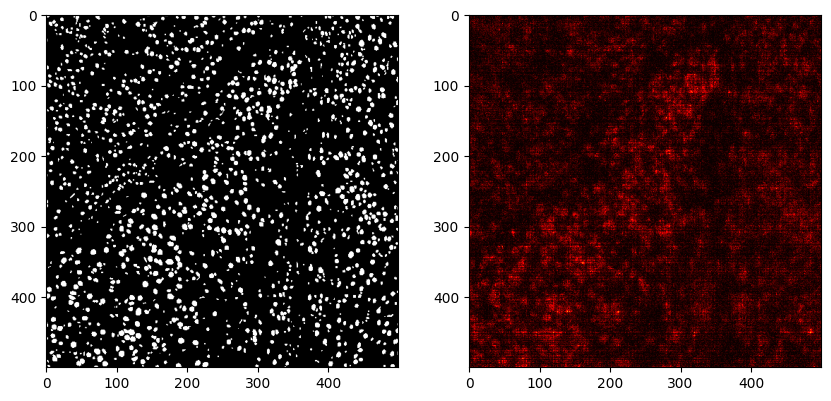

In [78]:
# Plot
x_min, x_max, y_min, y_max = 2000, 2500, 1500, 2000
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(seg_map[x_min:x_max, y_min:y_max]> 0, cmap="gray")
ax[1].imshow(gene_map_sum[x_min:x_max, y_min:y_max], cmap="hot")

## Stage 4: Cut map and seg into patches

In [80]:
gene_map_sum.shape

(3160, 2508)